In [1]:
import sys
sys.path.append('/Users/pschulam/Git/mypy')

In [227]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nips15
import adjustment

np.set_printoptions(precision=4)
%matplotlib inline

In [3]:
folds_dir = 'models/jmlr/folds'

def load_model(marker, fold, folds_dir=folds_dir):
    param_dir = os.path.join(folds_dir, marker, '{:02d}'.format(fold), 'param')
    return nips15.NipsModel.from_directory(param_dir)

def get_posteriors(model, data):
    P = [model.posterior(*d.unpack()) for d in data]
    P = np.array(P)
    return P

In [4]:
pfvc_spec = {'t' : 'years_seen_full',
             'y' : 'pfvc',
             'x1': ['female', 'afram'],
             'x2': ['female', 'afram', 'aca', 'scl']}

pfvc    = pd.read_csv('data/benchmark_pfvc.csv')
pfvc_pd = [nips15.PatientData.from_tbl(tbl, **pfvc_spec) for _, tbl in pfvc.groupby('ptid')]

tss_spec = {'t' : 'years_seen',
            'y' : 'tss',
            'x1': ['female', 'afram'],
            'x2': ['female', 'afram']}

tss = pd.read_csv('data/benchmark_tss.csv')
tss_match = ['ptid'] + tss_spec['x1']
tss = pd.merge(pfvc[tss_match], tss, 'left', tss_match)
tss_pd = [nips15.PatientData.from_tbl(tbl, **tss_spec) for _, tbl in tss.groupby('ptid')]

pdlco_spec = {'t' : 'years_seen',
              'y' : 'pdlco',
              'x1': ['female', 'afram'],
              'x2': ['female', 'afram']}

pdlco = pd.read_csv('data/benchmark_pdc.csv')
pdlco_match = ['ptid'] + pdlco_spec['x1']
pdlco = pd.merge(pfvc[pdlco_match], pdlco, 'left', pdlco_match)
pdlco_pd = [nips15.PatientData.from_tbl(tbl, **pdlco_spec) for _, tbl in pdlco.groupby('ptid')]

pv1_spec = {'t' : 'years_seen',
            'y' : 'pfev1',
            'x1': ['female', 'afram'],
            'x2': ['female', 'afram']}

pv1 = pd.read_csv('data/benchmark_pv1.csv')
pv1_match = ['ptid'] + pv1_spec['x1']
pv1 = pd.merge(pfvc[pv1_match], pv1, 'left', pv1_match)
pv1_pd = [nips15.PatientData.from_tbl(tbl, **pv1_spec) for _, tbl in pv1.groupby('ptid')]

combined_pd = list(zip(pfvc_pd, tss_pd, pdlco_pd, pv1_pd))

In [5]:
folds = pfvc.loc[:, ['ptid', 'fold']].drop_duplicates()
folds = dict(zip(folds['ptid'], folds['fold']))

In [72]:
def run_experiment(targ, aux, censor_time, fold,
                   patient_data, model_names, folds,
                   feat_censor=None, feat_alpha=0.05):
    
    k = fold
    models = [load_model(n, k) for n in model_names]
    
    feat_censor = censor_time if feat_censor is None else feat_censor
    
    train = [pd for pd in patient_data if not folds[pd[0].ptid] == k]
    test  = [pd for pd in patient_data if     folds[pd[0].ptid] == k]
    
    P = get_posteriors(models[targ], [pd[targ] for pd in train])
    Q = get_posteriors(models[targ], [pd[targ].truncate(censor_time) for pd in train])
    
    XX = []
    MM = []
    for i in aux:
        X = get_posteriors(models[i], [pd[i].truncate(feat_censor) for pd in train])
        M = adjustment.choose_features(P, X, feat_alpha)
        XX.append(X)
        MM.append(M)
        
    X = np.concatenate(XX, axis=1)
    M = np.concatenate(MM, axis=1)
    W = adjustment.fit_adjustment(P, Q, X, M)
    
    Ptest = get_posteriors(models[targ], [pd[targ] for pd in test])
    Qtest = get_posteriors(models[targ], [pd[targ].truncate(censor_time) for pd in test])
    
    XXtest = []
    for i in aux:
        X = get_posteriors(models[i], [pd[i].truncate(feat_censor) for pd in test])
        XXtest.append(X)
        
    Xtest = np.concatenate(XXtest, axis=1)
    Qhat  = adjustment.make_adjustment(W, Qtest, Xtest)
    
    entropy = adjustment.xentropy(Ptest) / Ptest.shape[0]
    entropy_orig = adjustment.xentropy(Ptest, Qtest) / Ptest.shape[0]
    entropy_adju = adjustment.xentropy(Ptest, Qhat)  / Ptest.shape[0]
    
    results = {
        'censor_time' : censor_time,
        'fold'        : fold,
        'entropy'     : entropy,
        'entropy_orig': entropy_orig,
        'entropy_adju': entropy_adju
    }
    
    return results

In [73]:
experiments = itertools.product([1.0, 2.0, 3.0, 4.0],
                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

results = [run_experiment(0, [1, 2], c, k, combined_pd, ['pfvc', 'tss', 'pdc'], folds, feat_alpha=0.01)
           for c, k in experiments]

In [74]:
results_tbl = pd.DataFrame(results)

In [98]:
results_tbl.groupby('censor_time').agg(np.mean)

,entropy,entropy_adju,entropy_orig,fold
censor_time,,,,
1,0.742342,1.288208,1.283397,5.5
2,0.742342,1.126825,1.124705,5.5
3,0.742342,1.038761,1.035633,5.5
4,0.742342,0.948979,0.945606,5.5


In [328]:
import pdb
from scipy.optimize import minimize
from scipy.misc import logsumexp
from sklearn.cross_validation import KFold
from mypy.models import softmax

def run_experiment2(targ, aux, censor_time, fold, patient_data, model_names, folds):
    k = fold
    models = [load_model(n, k) for n in model_names]

    train = [pd for pd in patient_data if not folds[pd[0].ptid] == k]
    test  = [pd for pd in patient_data if     folds[pd[0].ptid] == k]
    
    P = get_posteriors(models[targ], [pd[targ] for pd in train])
    Q = get_posteriors(models[targ], [pd[targ].truncate(censor_time) for pd in train])

    XX = []
    for i in aux:
        print('Making features for aux {}'.format(i))
        X = get_posteriors(models[i], [pd[i].truncate(censor_time) for pd in train])
        X = np.c_[ np.ones(X.shape[0]), X[:, 1:] ]
        XX.append(X)
        
    QQdev = [np.zeros_like(Q) for _ in XX]
    dev_folds = KFold(P.shape[0], 4, shuffle=True, random_state=0)
    for i, (dtrain, dtest) in enumerate(dev_folds):
        print('Training dev fold {}'.format(i))
        for m, X in enumerate(XX):
            print('Training marker {}'.format(m))
            W = adjustment.fit_adjustment2(P[dtrain], X[dtrain])
            QQdev[m][dtest] = adjustment.make_adjustment2(W, X[dtest])
            
    weight_attempts   = [interpolate(P, [Q] + QQdev, s) for s in range(100)]
    weight_perplexity = [perplexity(P, [Q] + QQdev, np.log(w)) for w in weight_attempts]
    weights = min(zip(weight_perplexity, weight_attempts))[1]
    
    WW = []
    for i, X in enumerate(XX):
        print('Training marker {} for real!'.format(i))
        W = adjustment.fit_adjustment2(P, X)
        WW.append(W)
        
    Ptest = get_posteriors(models[targ], [pd[targ] for pd in test])
    Qtest = get_posteriors(models[targ], [pd[targ].truncate(censor_time) for pd in test])
    
    XXtest = []
    for i in aux:
        X = get_posteriors(models[i], [pd[i].truncate(censor_time) for pd in test])
        X = np.c_[ np.ones(X.shape[0]), X[:, 1:] ]
        XXtest.append(X)
        
    QQtest = []
    for i, X in enumerate(XXtest):
        Qi = adjustment.make_adjustment2(WW[i], X)
        QQtest.append(Qi)
        
    Qhat = mixture(weights, [Qtest] + QQtest)
    
    entropy = adjustment.xentropy(Ptest) / Ptest.shape[0]
    entropy_orig = adjustment.xentropy(Ptest, Qtest) / Ptest.shape[0]
    entropy_adju = adjustment.xentropy(Ptest, Qhat)  / Ptest.shape[0]
    
    results = {
        'fold'        : fold,
        'censor_time' : censor_time,
        'entropy'     : entropy,
        'entropy_orig': entropy_orig,
        'entropy_adju': entropy_adju
    }
    
    return results


def interpolate(P, QQ, seed=1):
    rnd = np.random.RandomState(seed)
    
    M    = len(QQ)
    v    = rnd.normal(size=M)
    v[0] = 0.0
    
    obj = lambda x: perplexity(P, QQ, x)
    jac = lambda x: perplexity_jac(P, QQ, x)
    sol = minimize(obj, v, jac=jac, method='BFGS')
    
    if not sol.success:
        raise RuntimeError('Interpolation optimization failed.')
    
    w = softmax.softmax_func(sol.x)

    return w
    

def perplexity(P, QQ, v):
    w = softmax.softmax_func(v)
    Q = mixture(w, QQ)
    return - np.sum(P * np.log(Q)) / P.shape[0]


def perplexity_jac(P, QQ, v):
    M = v.size
    w = softmax.softmax_func(v)
    Q = mixture(w, QQ)
    
    dp_dw = np.zeros(M)
    for m in range(M):
        dp_dw[m] = np.sum(P * QQ[m] / Q)
        
    dw_dv = -softmax.softmax_grad(v)
    
    return np.dot(dp_dw, dw_dv) / P.shape[0]


def mixture(w, QQ):
    Q = np.zeros_like(QQ[0])
    for wi, Qi in zip(w, QQ):
        Q += wi * Qi
    return Q


def check_grad(f, x0, eps=1e-8):
    f0 = f(x0)
    n = x0.size
    g = np.zeros_like(x0)
    for i in range(n):
        dt = np.zeros_like(x0)
        dt[i] += eps
        f1 = f(x0 + dt)
        g[i] = (f1 - f0) / eps
        
    return g

In [200]:
experiments = itertools.product([1.0, 2.0, 3.0, 4.0],
                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

results2 = [run_experiment2(0, [1, 2], c, k, combined_pd, ['pfvc', 'tss', 'pdc'], folds)
            for c, k in experiments]

Making features for aux 1
Making features for aux 2
Training dev fold 0
Training marker 0
Training marker 1
Training dev fold 1
Training marker 0
Training marker 1
Training dev fold 2
Training marker 0
Training marker 1
Training dev fold 3
Training marker 0
Training marker 1
Training marker 0 for real!
Training marker 1 for real!
Making features for aux 1
Making features for aux 2
Training dev fold 0
Training marker 0
Training marker 1
Training dev fold 1
Training marker 0
Training marker 1
Training dev fold 2
Training marker 0
Training marker 1
Training dev fold 3
Training marker 0
Training marker 1
Training marker 0 for real!
Training marker 1 for real!
Making features for aux 1
Making features for aux 2
Training dev fold 0
Training marker 0
Training marker 1
Training dev fold 1
Training marker 0
Training marker 1
Training dev fold 2
Training marker 0
Training marker 1
Training dev fold 3
Training marker 0
Training marker 1
Training marker 0 for real!
Training marker 1 for real!
Maki

In [201]:
results2_tbl = pd.DataFrame(results2)[['censor_time', 'fold', 'entropy', 'entropy_adju', 'entropy_orig']]

In [202]:
results2_tbl.groupby('censor_time').agg(np.mean)

,fold,entropy,entropy_adju,entropy_orig
censor_time,,,,
1,5.5,0.742342,1.274268,1.283397
2,5.5,0.742342,1.124344,1.124705
3,5.5,0.742342,1.035084,1.035633
4,5.5,0.742342,0.945623,0.945606


In [204]:
experiments = itertools.product([1.0],
                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

results3 = [run_experiment2(0, [1, 2, 3], c, k, combined_pd, ['pfvc', 'tss', 'pdc', 'pv1'], folds)
            for c, k in experiments]

Making features for aux 1
Making features for aux 2
Making features for aux 3
Training dev fold 0
Training marker 0
Training marker 1
Training marker 2
Training dev fold 1
Training marker 0
Training marker 1
Training marker 2
Training dev fold 2
Training marker 0
Training marker 1
Training marker 2
Training dev fold 3
Training marker 0
Training marker 1
Training marker 2
Training marker 0 for real!
Training marker 1 for real!
Training marker 2 for real!
Making features for aux 1
Making features for aux 2
Making features for aux 3
Training dev fold 0
Training marker 0
Training marker 1
Training marker 2
Training dev fold 1
Training marker 0
Training marker 1
Training marker 2
Training dev fold 2
Training marker 0
Training marker 1
Training marker 2
Training dev fold 3
Training marker 0
Training marker 1
Training marker 2
Training marker 0 for real!
Training marker 1 for real!
Training marker 2 for real!
Making features for aux 1
Making features for aux 2
Making features for aux 3
Traini

In [205]:
results3_tbl = pd.DataFrame(results3)[['censor_time', 'fold', 'entropy', 'entropy_adju', 'entropy_orig']]

In [206]:
results3_tbl.groupby('censor_time').agg(np.mean)

,fold,entropy,entropy_adju,entropy_orig
censor_time,,,,
1,5.5,0.742342,1.270488,1.283397


In [244]:
def run_diagnosis2(targ, aux, censor_time, fold, patient_data, model_names, folds):
    k = fold
    models = [load_model(n, k) for n in model_names]

    train = [pd for pd in patient_data if not folds[pd[0].ptid] == k]
    test  = [pd for pd in patient_data if     folds[pd[0].ptid] == k]
    
#     P = get_posteriors(models[targ], [pd[targ] for pd in train])
#     Q = get_posteriors(models[targ], [pd[targ].truncate(censor_time) for pd in train])

#     XX = []
#     for i in aux:
#         print('Making features for aux {}'.format(i))
#         X = get_posteriors(models[i], [pd[i].truncate(censor_time) for pd in train])
#         X = np.c_[ np.ones(X.shape[0]), X[:, 1:] ]
#         XX.append(X)
        
#     QQdev = [np.zeros_like(Q) for _ in XX]
#     dev_folds = KFold(P.shape[0], 4, shuffle=True, random_state=0)
#     for i, (dtrain, dtest) in enumerate(dev_folds):
#         print('Training dev fold {}'.format(i))
#         for m, X in enumerate(XX):
#             print('Training marker {}'.format(m))
#             W = adjustment.fit_adjustment2(P[dtrain], X[dtrain])
#             QQdev[m][dtest] = adjustment.make_adjustment2(W, X[dtest])
            
#     weight_attempts   = [interpolate(P, [Q] + QQdev, s) for s in range(100)]
#     weight_perplexity = [perplexity(P, [Q] + QQdev, np.log(w)) for w in weight_attempts]
#     weights = min(zip(weight_perplexity, weight_attempts))[1]
    
#     WW = []
#     for i, X in enumerate(XX):
#         print('Training marker {} for real!'.format(i))
#         W = adjustment.fit_adjustment2(P, X)
#         WW.append(W)
        
    Ptest = get_posteriors(models[targ], [pd[targ] for pd in test])
    Qtest = get_posteriors(models[targ], [pd[targ].truncate(censor_time) for pd in test])
    
    return Ptest, Qtest
    
#     XXtest = []
#     for i in aux:
#         X = get_posteriors(models[i], [pd[i].truncate(censor_time) for pd in test])
#         X = np.c_[ np.ones(X.shape[0]), X[:, 1:] ]
#         XXtest.append(X)
        
#     QQtest = []
#     for i, X in enumerate(XXtest):
#         Qi = adjustment.make_adjustment2(WW[i], X)
#         QQtest.append(Qi)
        
#     Qhat = mixture(weights, [Qtest] + QQtest)
    
#     entropy = adjustment.xentropy(Ptest) / Ptest.shape[0]
#     entropy_orig = adjustment.xentropy(Ptest, Qtest) / Ptest.shape[0]
#     entropy_adju = adjustment.xentropy(Ptest, Qhat)  / Ptest.shape[0]
    
#     results = {
#         'fold'        : fold,
#         'censor_time' : censor_time,
#         'entropy'     : entropy,
#         'entropy_orig': entropy_orig,
#         'entropy_adju': entropy_adju
#     }
    
#     return results

In [245]:
dgn  = lambda k: run_diagnosis2(0, [1, 2, 3], 1.0, k, combined_pd, ['pfvc', 'tss', 'pdc', 'pv1'], folds)
PQ   = [dgn(k + 1) for k in range(10)]

In [249]:
P, Q = list(zip(*PQ))

In [250]:
P    = np.concatenate(P, axis=0)
Q    = np.concatenate(Q, axis=0)

In [253]:
def entropy(P):
    bits = - np.log2(P)
    bits[np.isinf(bits)] = 0
    return (P * bits).sum(axis=1)

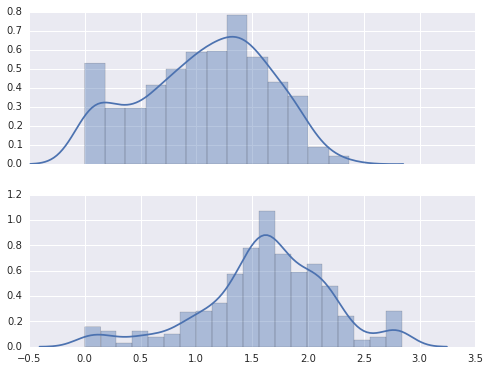

In [254]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
_ = sns.distplot(entropy(P), ax=ax[0])
_ = sns.distplot(entropy(Q), ax=ax[1])

In [294]:
entropies = pd.DataFrame({'p': entropy(P), 'q': entropy(Q),
                          'z_true': np.argmax(P, axis=1),
                          'z_pred': np.argmax(Q, axis=1)})

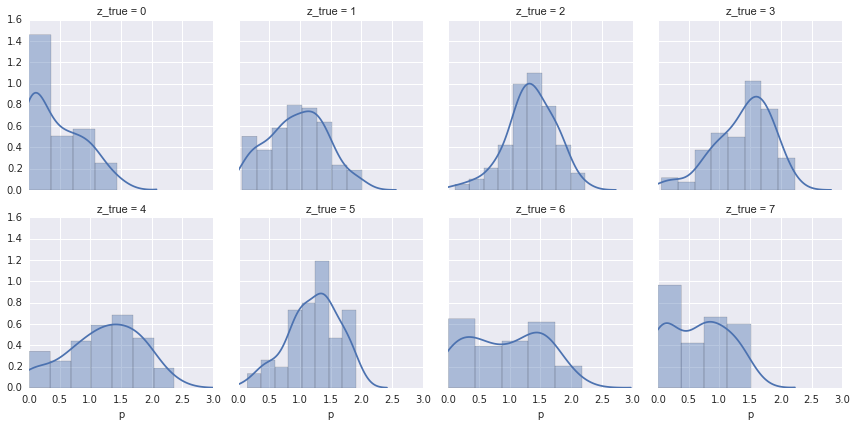

In [295]:
g = sns.FacetGrid(entropies, col='z_true', col_wrap=4, xlim=(0, 3), col_order=list(range(8)))
_ = g.map(sns.distplot, 'p')

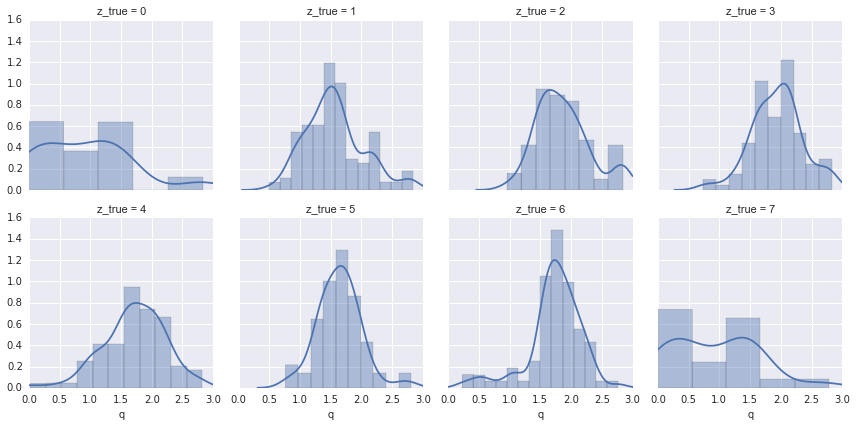

In [291]:
g = sns.FacetGrid(entropies, col='z_true', col_wrap=4, xlim=(0, 3), col_order=list(range(8)))
_ = g.map(sns.distplot, 'q')

In [270]:
z_true  = np.argmax(P, axis=1)
z_pred1 = np.argsort(Q, axis=1)[:, -1]
z_pred2 = np.argsort(Q, axis=1)[:, -2]
z_pred3 = np.argsort(Q, axis=1)[:, -3]

In [271]:
correct_1 = z_true == z_pred1
correct_1.mean()

0.60119047619047616

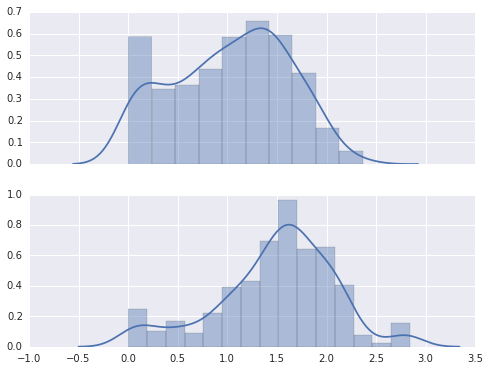

In [282]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
_ = sns.distplot(entropy(P[correct_1, :]), ax=ax[0])
_ = sns.distplot(entropy(Q[correct_1, :]), ax=ax[1])

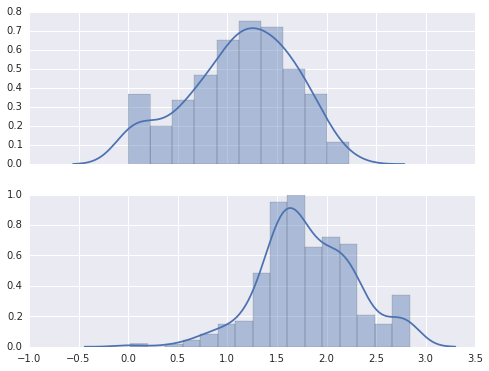

In [283]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
_ = sns.distplot(entropy(P[~correct_1, :]), ax=ax[0])
_ = sns.distplot(entropy(Q[~correct_1, :]), ax=ax[1])

In [272]:
z_comb1             = z_pred1.copy()
z_comb1[~correct_1] = z_pred2[~correct_1]

In [273]:
correct_2 = z_true == z_comb1
correct_2.mean()

0.81994047619047616

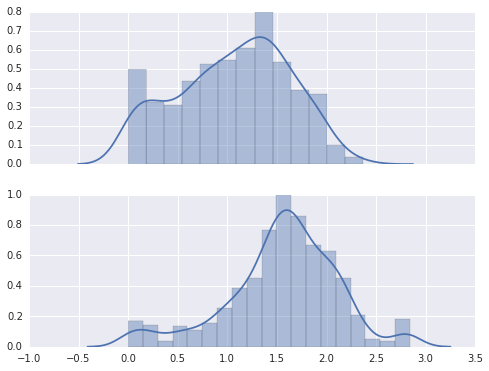

In [284]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
_ = sns.distplot(entropy(P[correct_2, :]), ax=ax[0])
_ = sns.distplot(entropy(Q[correct_2, :]), ax=ax[1])

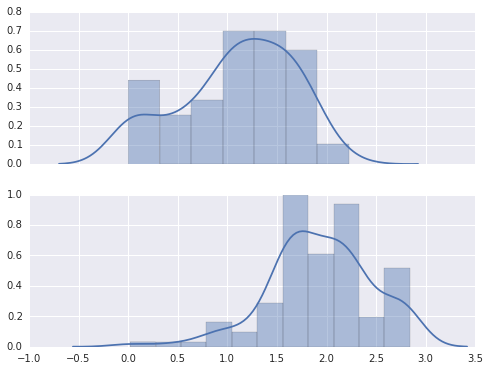

In [285]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
_ = sns.distplot(entropy(P[~correct_2, :]), ax=ax[0])
_ = sns.distplot(entropy(Q[~correct_2, :]), ax=ax[1])

In [275]:
z_comb2 = z_comb1.copy()
z_comb2[~correct_2] = z_pred3[~correct_2]

In [277]:
correct_3 = z_true == z_comb1
correct_3.mean()

0.81994047619047616

In [343]:
def run_experiment3(targ, aux, censor_time, fold, patient_data, model_names, folds):
    k = fold
    models = [load_model(n, k) for n in model_names]

    train = [pd for pd in patient_data if not folds[pd[0].ptid] == k]
    test  = [pd for pd in patient_data if     folds[pd[0].ptid] == k]
    
    P = get_posteriors(models[targ], [pd[targ] for pd in train])
    Q = get_posteriors(models[targ], [pd[targ].truncate(censor_time) for pd in train])
    
    P = map_encode(P)
    Q = map_encode(Q)

    XX = []
    for i in aux:
        print('Making features for aux {}'.format(i))
        X = get_posteriors(models[i], [pd[i].truncate(censor_time) for pd in train])
        X = np.c_[ np.ones(X.shape[0]), X[:, 1:] ]
        XX.append(X)
        
    QQdev = [np.zeros_like(Q) for _ in XX]
    dev_folds = KFold(P.shape[0], 4, shuffle=True, random_state=0)
    for i, (dtrain, dtest) in enumerate(dev_folds):
        print('Training dev fold {}'.format(i))
        for m, X in enumerate(XX):
            print('Training marker {}'.format(m))
            W = adjustment.fit_adjustment2(P[dtrain], X[dtrain])
            QQdev[m][dtest] = adjustment.make_adjustment2(W, X[dtest])
            
    for i, _ in enumerate(QQdev):
        QQdev[i] = map_encode(QQdev[i])
            
    weight_attempts   = [interpolate(P, [Q] + QQdev, s) for s in range(100)]
    weight_perplexity = [perplexity(P, [Q] + QQdev, np.log(w)) for w in weight_attempts]
    weights = min(zip(weight_perplexity, weight_attempts))[1]
    
    WW = []
    for i, X in enumerate(XX):
        print('Training marker {} for real!'.format(i))
        W = adjustment.fit_adjustment2(P, X)
        WW.append(W)
        
    Ptest = get_posteriors(models[targ], [pd[targ] for pd in test])
    Qtest = get_posteriors(models[targ], [pd[targ].truncate(censor_time) for pd in test])
    
    Ptest = map_encode(Ptest)
    Qtest = map_encode(Qtest)
    
    XXtest = []
    for i in aux:
        X = get_posteriors(models[i], [pd[i].truncate(censor_time) for pd in test])
        X = np.c_[ np.ones(X.shape[0]), X[:, 1:] ]
        XXtest.append(X)
        
    QQtest = []
    for i, X in enumerate(XXtest):
        Qi = adjustment.make_adjustment2(WW[i], X)
        QQtest.append(Qi)
        
    for i, _ in enumerate(QQtest):
        QQtest[i] = map_encode(QQtest[i])
        
    Qhat = mixture(weights, [Qtest] + QQtest)
    
    entropy = adjustment.xentropy(Ptest) / Ptest.shape[0]
    entropy_orig = adjustment.xentropy(Ptest, Qtest) / Ptest.shape[0]
    entropy_adju = adjustment.xentropy(Ptest, Qhat)  / Ptest.shape[0]
    
    results = {
        'fold'        : fold,
        'censor_time' : censor_time,
        'entropy'     : entropy,
        'entropy_orig': entropy_orig,
        'entropy_adju': entropy_adju
    }
    
    return results


def map_encode(P):
    cx = np.argmax(P, axis=1)
    rx = list(range(P.shape[0]))
    M  = 1e-2 * np.ones_like(P)
    M[rx, cx] = 1
    M /= M.sum(axis=1)[:, np.newaxis]
    return M

In [345]:
experiments = itertools.product([1.0],
                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

results4 = [run_experiment3(0, [1, 2], c, k, combined_pd, ['pfvc', 'tss', 'pdc', 'pv1'], folds)
            for c, k in experiments]

Making features for aux 1
Making features for aux 2
Training dev fold 0
Training marker 0
Training marker 1
Training dev fold 1
Training marker 0
Training marker 1
Training dev fold 2
Training marker 0
Training marker 1
Training dev fold 3
Training marker 0
Training marker 1
Training marker 0 for real!
Training marker 1 for real!
Making features for aux 1
Making features for aux 2
Training dev fold 0
Training marker 0
Training marker 1
Training dev fold 1
Training marker 0
Training marker 1
Training dev fold 2
Training marker 0
Training marker 1
Training dev fold 3
Training marker 0
Training marker 1
Training marker 0 for real!
Training marker 1 for real!
Making features for aux 1
Making features for aux 2
Training dev fold 0
Training marker 0
Training marker 1
Training dev fold 1
Training marker 0
Training marker 1
Training dev fold 2
Training marker 0
Training marker 1
Training dev fold 3
Training marker 0
Training marker 1
Training marker 0 for real!
Training marker 1 for real!
Maki

In [346]:
results4_tbl = pd.DataFrame(results4)

In [349]:
results4_tbl.groupby('censor_time').agg(np.mean)

,entropy,entropy_adju,entropy_orig,fold
censor_time,,,,
1,0.368931,1.797723,2.059643,5.5


In [348]:
results4_tbl

,censor_time,entropy,entropy_adju,entropy_orig,fold
0,1,0.368931,2.346117,2.527766,1
1,1,0.368931,1.953771,2.104837,2
2,1,0.368931,1.698098,2.058582,3
3,1,0.368931,1.768423,2.138826,4
4,1,0.368931,1.802381,1.947027,5
5,1,0.368931,1.680803,2.012405,6
6,1,0.368931,1.763931,2.149589,7
7,1,0.368931,1.606843,1.811068,8
8,1,0.368931,1.812236,2.036224,9
9,1,0.368931,1.544621,1.810104,10


In [350]:
experiments = itertools.product([1.0],
                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

results5 = [run_experiment3(0, [1, 2, 3], c, k, combined_pd, ['pfvc', 'tss', 'pdc', 'pv1'], folds)
            for c, k in experiments]

Making features for aux 1
Making features for aux 2
Making features for aux 3
Training dev fold 0
Training marker 0
Training marker 1
Training marker 2
Training dev fold 1
Training marker 0
Training marker 1
Training marker 2
Training dev fold 2
Training marker 0
Training marker 1
Training marker 2
Training dev fold 3
Training marker 0
Training marker 1
Training marker 2
Training marker 0 for real!
Training marker 1 for real!
Training marker 2 for real!
Making features for aux 1
Making features for aux 2
Making features for aux 3
Training dev fold 0
Training marker 0
Training marker 1
Training marker 2
Training dev fold 1
Training marker 0
Training marker 1
Training marker 2
Training dev fold 2
Training marker 0
Training marker 1
Training marker 2
Training dev fold 3
Training marker 0
Training marker 1
Training marker 2
Training marker 0 for real!
Training marker 1 for real!
Training marker 2 for real!
Making features for aux 1
Making features for aux 2
Making features for aux 3
Traini

In [351]:
results5_tbl = pd.DataFrame(results5)

In [352]:
results5_tbl.groupby('censor_time').agg(np.mean)

,entropy,entropy_adju,entropy_orig,fold
censor_time,,,,
1,0.368931,1.723166,2.059643,5.5


In [353]:
results5_tbl

,censor_time,entropy,entropy_adju,entropy_orig,fold
0,1,0.368931,2.203745,2.527766,1
1,1,0.368931,1.893088,2.104837,2
2,1,0.368931,1.606573,2.058582,3
3,1,0.368931,1.675484,2.138826,4
4,1,0.368931,1.752310,1.947027,5
5,1,0.368931,1.613787,2.012405,6
6,1,0.368931,1.726140,2.149589,7
7,1,0.368931,1.518787,1.811068,8
8,1,0.368931,1.788171,2.036224,9
9,1,0.368931,1.453575,1.810104,10


In [354]:
experiments = itertools.product([2.0, 4.0],
                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

results6 = [run_experiment3(0, [1, 2, 3], c, k, combined_pd, ['pfvc', 'tss', 'pdc', 'pv1'], folds)
            for c, k in experiments]

Making features for aux 1
Making features for aux 2
Making features for aux 3
Training dev fold 0
Training marker 0
Training marker 1
Training marker 2
Training dev fold 1
Training marker 0
Training marker 1
Training marker 2
Training dev fold 2
Training marker 0
Training marker 1
Training marker 2
Training dev fold 3
Training marker 0
Training marker 1
Training marker 2
Training marker 0 for real!
Training marker 1 for real!
Training marker 2 for real!
Making features for aux 1
Making features for aux 2
Making features for aux 3
Training dev fold 0
Training marker 0
Training marker 1
Training marker 2
Training dev fold 1
Training marker 0
Training marker 1
Training marker 2
Training dev fold 2
Training marker 0
Training marker 1
Training marker 2
Training dev fold 3
Training marker 0
Training marker 1
Training marker 2
Training marker 0 for real!
Training marker 1 for real!
Training marker 2 for real!
Making features for aux 1
Making features for aux 2
Making features for aux 3
Traini

In [355]:
results6_tbl = pd.DataFrame(results6)

In [356]:
results6_tbl.groupby('censor_time').agg(np.mean)

,entropy,entropy_adju,entropy_orig,fold
censor_time,,,,
2,0.368931,1.477924,1.730074,5.5
4,0.368931,0.941092,1.060079,5.5


In [357]:
experiments = itertools.product([8.0],
                                [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

results7 = [run_experiment3(0, [1, 2, 3], c, k, combined_pd, ['pfvc', 'tss', 'pdc', 'pv1'], folds)
            for c, k in experiments]

Making features for aux 1
Making features for aux 2
Making features for aux 3
Training dev fold 0
Training marker 0
Training marker 1
Training marker 2
Training dev fold 1
Training marker 0
Training marker 1
Training marker 2
Training dev fold 2
Training marker 0
Training marker 1
Training marker 2
Training dev fold 3
Training marker 0
Training marker 1
Training marker 2
Training marker 0 for real!
Training marker 1 for real!
Training marker 2 for real!
Making features for aux 1
Making features for aux 2
Making features for aux 3
Training dev fold 0
Training marker 0
Training marker 1
Training marker 2
Training dev fold 1
Training marker 0
Training marker 1
Training marker 2
Training dev fold 2
Training marker 0
Training marker 1
Training marker 2
Training dev fold 3
Training marker 0
Training marker 1
Training marker 2
Training marker 0 for real!
Training marker 1 for real!
Training marker 2 for real!
Making features for aux 1
Making features for aux 2
Making features for aux 3
Traini

In [358]:
results7_tbl = pd.DataFrame(results7)

In [359]:
results7_tbl.groupby('censor_time').agg(np.mean)

,entropy,entropy_adju,entropy_orig,fold
censor_time,,,,
8,0.368931,0.587163,0.598221,5.5
